Mean ROC-AUC: 0.792
Mean F1 Score: 0.629
Mean MCC Score: 0.530


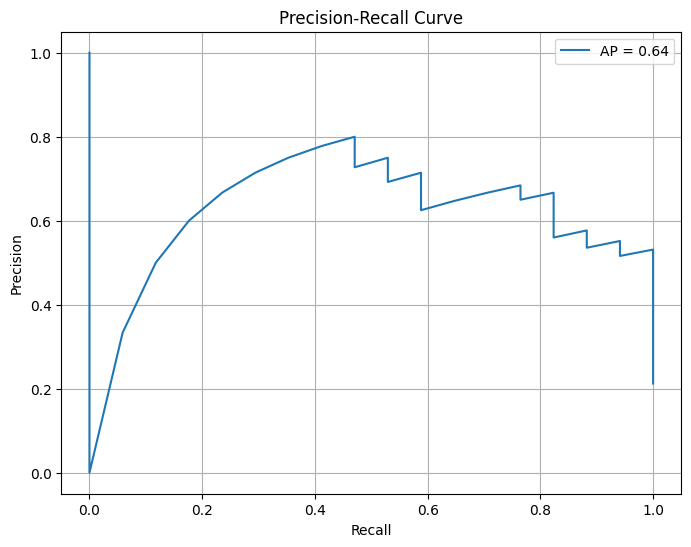

In [2]:
# Data processing and analysis
import pandas as pd
import numpy as np

# Model training and evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef, precision_recall_curve, auc
from sklearn.impute import SimpleImputer
# Resampling methods
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

%run dataInfo.ipynb

cleanTest = test_df
cleanTrain = train_df

# 2. Prepare training data
X_train_full = cleanTrain.drop(columns=['Class/ASD'])
y_train_full = cleanTrain['Class/ASD']

# 3. Initialize tools
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
model = LogisticRegression(class_weight='balanced', random_state=42)
smote = SMOTE(random_state=42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# 4. Cross-validation for training evaluation
roc_auc_scores, f1_scores, mcc_scores = [], [], []

# Store just the last fold's values for plotting
last_precision = None
last_recall = None
last_avg_precision = None

for train_idx, val_idx in cv.split(X_train_full, y_train_full):
    X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    # Preprocessing
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)

    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Train model
    model.fit(X_resampled, y_resampled)

    # Evaluate
    y_pred = model.predict(X_val)
    roc_auc_scores.append(roc_auc_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    mcc_scores.append(matthews_corrcoef(y_val, y_pred))

    from sklearn.metrics import precision_recall_curve, average_precision_score

    # Get predicted probabilities for the positive class
    y_proba = model.predict_proba(X_val)[:, 1]

    # Precision-Recall values
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    avg_precision = average_precision_score(y_val, y_proba)

    # Save the last fold's values for plotting later
    last_precision = precision
    last_recall = recall
    last_avg_precision = avg_precision

X_test = cleanTest.loc[:, cleanTest.columns.isin(X_train_full.columns)]

# 5. Print evaluation results
print(f'Mean ROC-AUC: {np.mean(roc_auc_scores):.3f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.3f}')
print(f'Mean MCC Score: {np.mean(mcc_scores):.3f}')

# 6. Train final model on full cleanTrain
X_train_processed = imputer.fit_transform(X_train_full)
X_train_processed = scaler.fit_transform(X_train_processed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train_full)

model.fit(X_train_resampled, y_train_resampled)

# 7. Prepare cleanTest for prediction
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

# 8. Predict on test data
test_predictions = model.predict(X_test)
test_probabilities = model.predict_proba(X_test)[:, 1]

# 9. Add predictions to test set
cleanTest_with_predictions = cleanTest.copy()
cleanTest_with_predictions['Predicted_Class'] = test_predictions
cleanTest_with_predictions['Probability'] = test_probabilities

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
